In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

if torch.backends.mps.is_available():
    device = torch.device('mps')
    print( f'you are using a Mac-based GPU' )
elif torch.cuda().is_available():
    device = torch.cuda.device(0)
    print( 'You are using a '+str(torch.cuda.get_device_name(0)) )
else: 
    device = torch.device('cpu')
    print( f'you are using a: {device}' )

you are using a Mac-based GPU


In [2]:
# Reproducibility in RNG
seed = 14
torch.manual_seed( seed )
np.random.seed( seed )
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)

## Import the dataset
---

In [4]:
#@title 1. Import the dataset
from utils import *

task = 'cifar100'
if task =='cifar10':
    num_classes = 10
if task =='cifar100':
    num_classes = 100
batch_size = 128
image_size = 32

train_loader, test_loader = generate_dataset( task=task, train_batch_size=batch_size, test_batch_size=batch_size, image_size=image_size )

## Import the Model
---

In [5]:
from utils_mobilenet_v2 import mobilenet_v2_noise as mobilenet_v2
from utils_mobilenet_v2 import MobileNetV2
from models_utils import Linear

def get_model( weights='IMAGENET1K_V2', out_features=10, noise_inference=False, noise_inference_bn=False, 
               noise_sd=0.05, width_mult=0.4, inverted_residual_setting=None ):
    '''Function that imports a MobileNetV2 model, with the option of loading the pre-trained parameters
    weights : if None, it will initialize the parameters from scratch, otherwise use "IMAGENET1K_V2" for good performance
    out_features : the size of the output layer
    noise_inference : activates STE when True
    noise_sd : the amount of noise for the STE
    '''
    if weights == 'IMAGENET1K_V2' or weights == 'IMAGENET1K_V1' :
        model = mobilenet_v2( weights=weights, noise_inference=noise_inference, noise_inference_bn=noise_inference_bn, noise_sd=noise_sd )
    elif weights == 'cifar_specs':
        inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                [6, 24, 2, 1],
                [6, 32, 3, 1],
                [6, 64, 4, 2],
                [6, 96, 3, 1],
                [6, 160, 3, 2],
                [6, 320, 1, 1],
            ]
        model = MobileNetV2( num_classes=out_features, width_mult=width_mult, 
                             noise_inference=noise_inference, noise_inference_bn=noise_inference_bn, noise_sd=noise_sd, inverted_residual_setting=inverted_residual_setting )
    elif weights == 'cifar_specs_shallow':
        inverted_residual_setting = [
                # t, c, n, s
                [1, 16, 1, 1],
                #[6, 24, 2, 1],
                [6, 32, 3, 1],
                #[6, 64, 4, 2],
                [6, 96, 3, 1],
                #[6, 160, 3, 2],
                [6, 320, 1, 1],
            ]
        model = MobileNetV2( num_classes=out_features, width_mult=0.4, 
                             noise_inference=noise_inference, noise_inference_bn=noise_inference_bn, noise_sd=noise_sd, inverted_residual_setting=inverted_residual_setting )
    else:
        model = mobilenet_v2( weights=None, noise_inference=noise_inference, noise_inference_bn=noise_inference_bn, noise_sd=noise_sd )
    model.classifier[1] = Linear( in_features=model.classifier[1].in_features, out_features=out_features, 
                                   noise_inference=noise_inference, noise_sd=noise_sd )
    model.classifier[0].p = 0.2
    return model

#model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, noise_inference_bn=True )

In [5]:
def get_tot_model_params(model, verbose=True):
    tot_params = 0
    params = []
    for p in model.parameters():
        params.append( p )
        tot_params += ( len( p.flatten() ) )
    if verbose: print( f'Parameter count: {tot_params}' )
    return tot_params

model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, width_mult=0.4, noise_inference_bn=False )
_ = get_tot_model_params( model )

Parameter count: 617828


In [5]:
model.classifier

Sequential(
  (0): Dropout(p=0.0, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True, noise_inference=True)
)

In [6]:
### this can go as I have put it on utils.py

def training_algo( training_type, model, data_loaders, optimizer=None, criterion=None, scheduler=None, out_activation=None,
                   device='cpu', lr=1e-3, clip_w=2.5, epochs=10, epochs_noise=2, 
                   noise_sd=1e-2, noise_every=100, levels=None, num_levels=15, print_every=1, verbose=False,
                   save_checkpoint_path=None, load_checkpoint_path=None  ):

    train_loader, test_loader = data_loaders
    if criterion is None: criterion = torch.nn.NLLLoss() #torch.nn.CrossEntropyLoss()
    if optimizer is None: optimizer = torch.optim.SGD( model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4 )
    if scheduler == 'standard': scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones=[100, 150, 200], gamma=0.5 )
    if out_activation is None: out_activation = torch.nn.LogSoftmax( dim=-1 )

    if load_checkpoint_path is not None:
        checkpoint = torch.load( load_checkpoint_path, map_location='cpu' )
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if 'scheduler_state_dict' in checkpoint.keys(): scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch_start = checkpoint['epoch']
    else:
        model = model.to(device)
        epoch_start = 0
    

    losses_train, accs_train = [], []
    for e in range(epochs):
        losses = []
        correct = 0
        tot_samples = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            yhat = model( x )
            y_soft = out_activation( yhat )
            loss = criterion( y_soft, y.long() )
            loss.backward()

            if training_type == 'qat_noise' or training_type == 'qat':
                for p in list(model.parameters()):
                        if hasattr(p,'hid'):
                            p.data.copy_(p.hid)

            optimizer.step()
            if scheduler is not None: scheduler.step()
            losses.append( loss.item() )
            correct += torch.eq( torch.argmax(yhat, dim=1), y ).cpu().sum()
            tot_samples += len(y)

            if e+1 > epochs - epochs_noise and batch_idx%noise_every==0 and training_type == 'noise_fine_tuning':
               with torch.no_grad():
                   for p in model.parameters():
                       delta_w = torch.abs( p.max()-p.min() )
                       n = torch.randn_like( p )*(noise_sd*delta_w)
                       p.copy_( p+n )
            
            if clip_w is not None:
                with torch.no_grad():
                    for p in model.parameters():
                        std_w = torch.std( p )
                        p.clip_( -std_w*clip_w, +std_w*clip_w )

            if training_type == 'qat':
                for p in list(model.parameters()):  # updating the hid attribute
                    if hasattr(p,'hid'):
                        p.hid.copy_(p.data)
                    p.data = quantize( parameters=p.data, levels=levels, num_levels=num_levels, device=device )

            if training_type == 'qat_noise':
                for p in list(model.parameters()):  # updating the hid attribute
                    if hasattr(p,'hid'):
                        p.hid.copy_(p.data)
                    p.data = quantize( parameters=p.data, levels=levels, num_levels=num_levels, device=device )
                    p.data.add_( torch.randn_like(p.data)*noise_sd )

        acc_train = correct/tot_samples
        loss_train = np.mean(losses)
        if verbose and e%print_every==0:
            print( f'Train Epoch {e+1}, Train accuracy {acc_train*100:.2f}% Train loss {loss_train:.4f}' )
        accs_train.append(acc_train); losses_train.append(loss_train)

    if save_checkpoint_path is not None:
        torch.save({
            'epoch': epochs+epoch_start,
            'model_state_dict': model.to('cpu').state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': loss.item(),
            }, save_checkpoint_path.format( epochs+epoch_start+1 ))
        print(f'Checkpoint saved at: {save_checkpoint_path}')


    with torch.no_grad():
        losses = []
        correct = 0
        tot_samples = 0
        model = model.to(device).eval()
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            yhat = model( x )
            y_soft = out_activation( yhat )
            loss = criterion( y_soft, y.long() )
            losses.append( loss.item() )
            correct += torch.eq( torch.argmax(yhat, dim=1), y ).cpu().sum()
            tot_samples += len(y)
        acc_test = correct/tot_samples
        loss_test = np.mean(losses)
        if verbose: print( f'Tot epochs {epochs+epoch_start} -- Test accuracy {acc_test*100:.2f}% Test loss {loss_test:.4f}' )

    return model, [accs_train, losses_train], [acc_test, loss_test]


def testing( model, test_loader, criterion=None, out_activation=None, device='cpu', verbose=True ):
    '''The function assessing the test classification accuracy of the model.
    model: model of choice
    test_loader: the test dataloader for the task of choice
    verbose: if True, makes the function output the test accuracy and loss'''
    model = model.to(device).eval()
    losses = []
    correct, tot_samples = 0, 0
    if criterion is None: criterion = torch.nn.NLLLoss()
    if out_activation is None: out_activation = torch.nn.LogSoftmax( dim=-1 )
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        yhat = model( x )
        y_soft = out_activation( yhat )
        loss = criterion( y_soft, y.long() )
        losses.append( loss.item() )
        correct += torch.eq( torch.argmax(yhat, dim=1), y ).cpu().sum()
        tot_samples += len(y)
    acc_test = correct/tot_samples
    loss_test = np.mean(losses)
    if verbose: print( f'-- Test accuracy {acc_test*100:.2f}% Test loss {loss_test:.4f}' )
    return acc_test, loss_test


## CIFAR 10
---

#### ----> Training

In [6]:
epochs = 25
epochs_load = 25
lr = 1e-1

noise_inference, noise_sd_ste = True, 0.05
data_loaders = [train_loader, test_loader] # [trainloader, testloader]
#model = get_model(weights='IMAGENET1K_V2', noise_inference=noise_inference, noise_sd=noise_sd_ste, out_features=num_classes)
model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=noise_inference, noise_inference_bn=noise_inference, noise_sd=noise_sd_ste )
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4 )
if noise_inference:
    scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones=[50, 100, 150], gamma=0.1 )
else: scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones=[100, 150, 200], gamma=0.5 )

model_type = {False:'normal', True:'ste{}'}
root_path = '/Users/filippomoro/Documents/Memristor-Aware-Training/Models'
save_checkpoint_path = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[noise_inference].format(noise_sd_ste), epochs+epochs_load ) # epochs_load+epochs
if epochs_load == 0:
    load_checkpoint_path = None
else:
    load_checkpoint_path = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[True].format(noise_sd_ste), epochs_load )

model_trained, [accs_train, losses_train], [acc_test, loss_test] = training_algo( training_type='normal', model=model, data_loaders=data_loaders,
                                                                                criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                                                                                clip_w=None, lr=lr, epochs=epochs, epochs_noise=2, 
                                                                                print_every=1, verbose=True, device=device,
                                                                                save_checkpoint_path=save_checkpoint_path,
                                                                                load_checkpoint_path=load_checkpoint_path )

Train Epoch 1, Train accuracy 85.29% Train loss 0.4227
Train Epoch 2, Train accuracy 85.39% Train loss 0.4168
Train Epoch 3, Train accuracy 85.58% Train loss 0.4148
Train Epoch 4, Train accuracy 85.47% Train loss 0.4162
Train Epoch 5, Train accuracy 85.84% Train loss 0.4108
Train Epoch 6, Train accuracy 85.70% Train loss 0.4109
Train Epoch 7, Train accuracy 85.59% Train loss 0.4088
Train Epoch 8, Train accuracy 85.84% Train loss 0.4064
Train Epoch 9, Train accuracy 85.65% Train loss 0.4090
Train Epoch 10, Train accuracy 85.90% Train loss 0.4059
Train Epoch 11, Train accuracy 85.86% Train loss 0.4057
Train Epoch 12, Train accuracy 85.95% Train loss 0.3995
Train Epoch 13, Train accuracy 86.18% Train loss 0.3956
Train Epoch 14, Train accuracy 85.93% Train loss 0.4012
Train Epoch 15, Train accuracy 86.10% Train loss 0.3971
Train Epoch 16, Train accuracy 86.23% Train loss 0.3963
Train Epoch 17, Train accuracy 86.46% Train loss 0.3952
Train Epoch 18, Train accuracy 86.12% Train loss 0.3942
T

#### ----> Testing with Noise

In [7]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2]) #np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
# noise_sd_list = np.array([0]) 
acc_test_c10_normal = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_c10_mat    = np.zeros( (n_models, len(noise_sd_list)) )

### model path
root_path = '/Users/filippomoro/Documents/Memristor-Aware-Training/Models'
model_type = {False:'normal', True:'ste{}'}
save_checkpoint_path = None #root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[noise_inference], epochs_load+epochs )
load_checkpoint_path_normal = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[False].format(0.05), 225 )
load_checkpoint_path_mat    = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[True].format(0.05), 50 )

with torch.no_grad():
    for n, noise_sd in enumerate(noise_sd_list):
        for m in range( n_models ):
            # Trained without noise
            model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, noise_sd=noise_sd/2 ) # noise_inference=True
            checkpoint = torch.load( load_checkpoint_path_normal, map_location='cpu' )
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()
            acc_test_noise, loss_test_noise = testing( model=model, test_loader=test_loader, device=device, verbose=False )
            acc_test_c10_normal[m, n] = acc_test_noise

            # Trained with noise (STE)
            model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, noise_sd=noise_sd/2 ) # noise_inference=True
            checkpoint = torch.load( load_checkpoint_path_mat, map_location='cpu' )
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()
            acc_test_noise, loss_test_noise = testing( model=model, test_loader=test_loader, device=device, verbose=False )
            acc_test_c10_mat[m, n] = acc_test_noise
        print( f'Noise Level {noise_sd*100}% Acc normal: {acc_test_c10_normal[:,n].mean()*100:.2f}%, Acc MAT: {acc_test_c10_mat[:,n].mean()*100:.2f}%' )

Noise Level 0.0% Acc normal: 90.95%, Acc MAT: 90.39%
Noise Level 1.0% Acc normal: 90.73%, Acc MAT: 90.40%
Noise Level 5.0% Acc normal: 86.77%, Acc MAT: 89.64%
Noise Level 10.0% Acc normal: 63.51%, Acc MAT: 86.53%
Noise Level 15.0% Acc normal: 26.66%, Acc MAT: 76.06%
Noise Level 20.0% Acc normal: 13.50%, Acc MAT: 48.33%


In [9]:
import pickle
dict_results_cifar10 = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_c10_normal' : acc_test_c10_normal,
    'acc_test_c10_mat' : acc_test_c10_mat,
}

dir_save = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results/CIFAR10_MobilenetV2.pkl'
pickle.dump( dict_results_cifar10, open( dir_save, 'wb' ) )

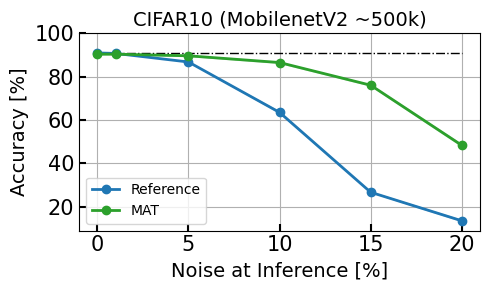

In [15]:
import pickle

dir_load = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results/CIFAR10_MobilenetV2.pkl'
dict_results = pickle.load( open(dir_load, 'rb') )

noise_sd_list = dict_results['noise_sd_list']
acc_test_vanilla = 100*dict_results['acc_test_c10_normal']
acc_test_vanilla_ref = 100*dict_results['acc_test_c10_normal'][:,0]
acc_test_mat = 100*dict_results['acc_test_c10_mat']

fig, ax = plt.subplots( figsize=(5,3) )
# reference accuracy w/out noise
ax.hlines( np.mean( acc_test_vanilla_ref, axis=0 ), noise_sd_list[0]*100, noise_sd_list[-1]*100, lw=1, linestyle='-.', color='k')
# vanilla training
ax.plot( 100*noise_sd_list, np.mean( acc_test_vanilla, axis=0 ), lw=2, marker='o', ms=6, label='Reference')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_vanilla, axis=0, q=0.5-0.38 ), np.quantile( acc_test_vanilla, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in forward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_mat, axis=0 ), lw=2, marker='o', ms=6, label='MAT', color='tab:green')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_mat, axis=0, q=0.5-0.38 ), np.quantile( acc_test_mat, axis=0, q=0.5+0.38 ), alpha=0.3, color='tab:green' )
ax.tick_params( which='major', labelsize=15, direction='in', size=5, width=1.5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
#ax.set_xscale('log')
ax.set_yticks( np.arange( 20,110,20 ) )
ax.set_title('CIFAR10 (MobilenetV2 ~500k)', size=14)
ax.set_xlabel('Noise at Inference [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()
ax.legend( prop={'size':10} )

## saving the plot
plt.tight_layout()
root_path_results = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results'
file_save_plot = root_path_results + '/CIFAR10_MAT.png'
fig.savefig( file_save_plot, dpi=300, transparent=True )


### CIFAR 100
---

In [10]:
epochs = 5
epochs_load = 25
lr = 1e-1

noise_inference, noise_sd_ste = True, 0.1
data_loaders = [train_loader, test_loader] # [trainloader, testloader]
#model = get_model(weights='IMAGENET1K_V2', noise_inference=noise_inference, noise_sd=noise_sd_ste, out_features=num_classes)
model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=noise_inference, noise_inference_bn=noise_inference, noise_sd=noise_sd_ste )
criterion = torch.nn.NLLLoss() #torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4 )
scheduler = torch.optim.lr_scheduler.MultiStepLR( optimizer, milestones=[25, 50, 75, 100], gamma=0.5 )

model_type = {False:'normal', True:'ste{}'}
root_path = '/Users/filippomoro/Documents/Memristor-Aware-Training/Models'
save_checkpoint_path = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[noise_inference].format(noise_sd_ste), epochs ) # epochs_load+epochs
if epochs_load > 0:
    load_checkpoint_path = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[noise_inference].format(0.05), epochs_load )
else: load_checkpoint_path = None

model_trained, [accs_train, losses_train], [acc_test, loss_test] = training_algo( training_type='normal', model=model, data_loaders=data_loaders,
                                                                                criterion=criterion, optimizer=optimizer, scheduler=scheduler,
                                                                                clip_w=None, lr=lr, epochs=epochs, epochs_noise=2, 
                                                                                print_every=1, verbose=True, device=device,
                                                                                save_checkpoint_path=save_checkpoint_path,
                                                                                load_checkpoint_path=load_checkpoint_path )

Train Epoch 1, Train accuracy 11.02% Train loss 3.8744
Train Epoch 2, Train accuracy 14.39% Train loss 3.5753
Train Epoch 3, Train accuracy 15.84% Train loss 3.4780
Train Epoch 4, Train accuracy 17.00% Train loss 3.4054
Train Epoch 5, Train accuracy 17.49% Train loss 3.3747
Checkpoint saved at: /Users/filippomoro/Documents/Memristor-Aware-Training/Models/cifar100_ste0.1_epochs5.pt
Tot epochs 205 -- Test accuracy 19.87% Test loss 3.2501


In [7]:
n_models = 5
noise_sd_list = np.array([0, 0.01, 0.05, 0.1, 0.15, 0.2]) #np.array([0, 0.01, 0.02, 0.04, 0.05, 0.07, 0.1, 0.15])
# noise_sd_list = np.array([0]) 
acc_test_c100_normal = np.zeros( (n_models, len(noise_sd_list)) )
acc_test_c100_mat    = np.zeros( (n_models, len(noise_sd_list)) )

### model path
root_path = '/Users/filippomoro/Documents/Memristor-Aware-Training/Models'
model_type = {False:'normal', True:'ste{}'}
save_checkpoint_path = None #root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[noise_inference], epochs_load+epochs )
load_checkpoint_path_normal = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[False].format(0.05), 175 )
load_checkpoint_path_mat    = root_path + '/{}_{}_epochs{}.pt'.format( task, model_type[True].format(0.05), 25 )

with torch.no_grad():
    for n, noise_sd in enumerate(noise_sd_list):
        for m in range( n_models ):
            # Trained without noise
            model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, noise_sd=noise_sd/2 ) # noise_inference=True
            checkpoint = torch.load( load_checkpoint_path_normal, map_location='cpu' )
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()
            acc_test_noise, loss_test_noise = testing( model=model, test_loader=test_loader, device=device, verbose=False )
            acc_test_c100_normal[m, n] = acc_test_noise

            # Trained with noise (STE)
            model = get_model( weights = 'cifar_specs', out_features=num_classes, noise_inference=True, noise_sd=noise_sd/2 ) # noise_inference=True
            checkpoint = torch.load( load_checkpoint_path_mat, map_location='cpu' )
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            model.eval()
            acc_test_noise, loss_test_noise = testing( model=model, test_loader=test_loader, device=device, verbose=False )
            acc_test_c100_mat[m, n] = acc_test_noise
        print( f'Noise Level {noise_sd*100}% Acc normal: {acc_test_c100_normal[:,n].mean()*100:.2f}%, Acc MAT: {acc_test_c100_mat[:,n].mean()*100:.2f}%' )

Noise Level 0.0% Acc normal: 66.90%, Acc MAT: 65.06%
Noise Level 1.0% Acc normal: 66.68%, Acc MAT: 65.00%
Noise Level 5.0% Acc normal: 60.24%, Acc MAT: 63.42%
Noise Level 10.0% Acc normal: 35.17%, Acc MAT: 57.35%
Noise Level 15.0% Acc normal: 8.06%, Acc MAT: 40.34%
Noise Level 20.0% Acc normal: 2.17%, Acc MAT: 14.52%


In [9]:
import pickle
dict_results_cifar100 = {
    'n_models' : n_models,
    'noise_sd_list' : noise_sd_list,
    'acc_test_c100_normal' : acc_test_c100_normal,
    'acc_test_c100_mat' : acc_test_c100_mat,
}

dir_save = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results/CIFAR100_MobilenetV2.pkl'
pickle.dump( dict_results_cifar100, open( dir_save, 'wb' ) )

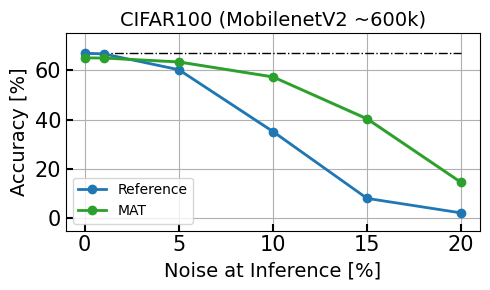

In [16]:
import pickle

dir_load = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results/CIFAR100_MobilenetV2.pkl'
dict_results = pickle.load( open(dir_load, 'rb') )

noise_sd_list = dict_results['noise_sd_list']
acc_test_vanilla = 100*dict_results['acc_test_c100_normal']
acc_test_vanilla_ref = 100*dict_results['acc_test_c100_normal'][:,0]
acc_test_mat = 100*dict_results['acc_test_c100_mat']

fig, ax = plt.subplots( figsize=(5,3) )
# reference accuracy w/out noise
ax.hlines( np.mean( acc_test_vanilla_ref, axis=0 ), noise_sd_list[0]*100, noise_sd_list[-1]*100, lw=1, linestyle='-.', color='k')
# vanilla training
ax.plot( 100*noise_sd_list, np.mean( acc_test_vanilla, axis=0 ), lw=2, marker='o', ms=6, label='Reference')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_vanilla, axis=0, q=0.5-0.38 ), np.quantile( acc_test_vanilla, axis=0, q=0.5+0.38 ), alpha=0.3 )
# with the noise in forward phase
ax.plot( 100*noise_sd_list, np.mean( acc_test_mat, axis=0 ), lw=2, marker='o', ms=6, label='MAT', color='tab:green')
ax.fill_between( 100*noise_sd_list, np.quantile( acc_test_mat, axis=0, q=0.5-0.38 ), np.quantile( acc_test_mat, axis=0, q=0.5+0.38 ), alpha=0.3, color='tab:green' )
ax.tick_params( which='major', labelsize=15, direction='in', size=5, width=1.5 )
ax.tick_params( which='minor', direction='in', size=2.5 )
#ax.set_xscale('log')
ax.set_yticks( np.arange( 0,80,20 ) )
ax.set_ylim( -5, 75 )
ax.set_title('CIFAR100 (MobilenetV2 ~600k)', size=14)
ax.set_xlabel('Noise at Inference [%]', size=14)
ax.set_ylabel('Accuracy [%]', size=14)
ax.grid()
ax.legend( prop={'size':10}, loc=3 )

## saving the plot
plt.tight_layout()
root_path_results = '/Users/filippomoro/Documents/Memristor-Aware-Training/Results'
file_save_plot = root_path_results + '/CIFAR100_MAT.png'
fig.savefig( file_save_plot, dpi=300, transparent=True )
